In [14]:
%pylab inline
import glob

Populating the interactive namespace from numpy and matplotlib


In [15]:
# Get data 
import pandas as pd
from PIL import Image

def get_names():
  names = pd.read_csv('signnames.csv')
  for i in names['ClassId']:
    yield i

folder = []
for i in glob.glob('data_train/*'):
  folder.append(i)
  
folder.sort()

images = []
labels = []
gen = get_names()
for i in folder:
  aux = next(gen)
  for j in glob.glob((i+'/*.ppm')):
    temp = Image.open(j)
    keep = temp.copy()
    images.append(keep)
    labels.append(aux)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from tqdm import trange

In [17]:
# Resize to (33, 33) and convert to tensor
tfms = transforms.Compose([transforms.Resize((33, 33)), transforms.ToTensor(),])

In [18]:
# Apply transforms
imgs = [tfms(i) for i in images]
imgs = torch.stack(imgs)

labels = torch.tensor(labels).long()

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(imgs, labels, random_state=42)

In [20]:
# CNN
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 43)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [35]:
BS = 100
trainset = list(zip(X_train, Y_train))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS, 
                                          shuffle=False, num_workers=2)

loss 0.00 accuracy 1.00: 100%|██████████| 10/10 [19:40<00:00, 118.01s/it]


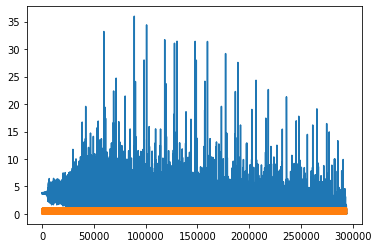

In [45]:
net = Net()

loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.0)

losses, accuracies = [], []
for i in (t := trange(10)):
  for i, data in enumerate(trainloader, 0):
    X, Y = data
    net.zero_grad()

    # forward (contains activation function inside)
    out = net(X)

    # Loss function
    loss = loss_function(out, Y)
    loss = loss.mean()

    # Bacward and optimizer
    loss.backward()
    optim.step()

    # Stats
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    accuracy = accuracy.item()
    loss = loss.item()
    accuracies.append(accuracy)
    losses.append(loss)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plot(losses)
plot(accuracies)

In [46]:
net.eval()
Y_pred = net(X_test)

In [47]:
(torch.argmax(Y_pred, dim=1) == Y_test).numpy().mean()

0.9713353055187187